<font size=5 >The codes are used to draw figure 1, figure2, figure 3, figure S3</font>

In [1]:
# import
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ternary
from scipy import odr
from scipy.stats import t
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import piecewise_regression
from brokenaxes import brokenaxes
import uncertainties as unc
import uncertainties.unumpy as unp
from collections import OrderedDict
from ternary.helpers import simplex_iterator


# functions

## Define vegetation color

In [2]:
grass = np.array([251/255, 240/255, 130/255])   # yellow
shrub = np.array([68/255, 108/255, 234/255])   # grey blue
bare  = np.array([171/255, 45/255, 50/255])   # red

# grass = np.array([0/255, 255/255, 0/255])   # green
# shrub = np.array([0/255, 0/255, 255/255])   # blue
# bare  = np.array([255/255, 0/255, 0/255])   # red

def color_point(x, y, z, scale):
    k=1 # Alpha
    color = (x*bare + y*grass + z*shrub) / float(scale)
    r_new = round(color[0],2)
    g_new = round(color[1],2)
    b_new = round(color[2],2)

    return (r_new, g_new, b_new, k)


## Generate color heatmap

In [3]:
# generate data for the heatmap
def generate_heatmap_data(scale=10):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

## Draw confidence interval for linear regression

In [4]:
# define a linear function
def func(x, a, b):
    return a * x + b


def draw_interval(breakpoints,ndvi_nt,year_nt,color,draw=False,draw_legend=False,bax=plt.figure()):
    
    for j in np.arange(len(breakpoints)-1):
        x = []
        y = []
        
        
        for i in np.arange(len(ndvi_nt)):
            if np.isnan(ndvi_nt[i])==False:
                if ((year_nt[i]>=breakpoints[j])&(year_nt[i]<=breakpoints[j+1])):
                    x.append(year_nt[i])
                    y.append(ndvi_nt[i])
                    

        popt, pcov = curve_fit(func, x, y)
        a, b = unc.correlated_values(popt, pcov)
        px = np.linspace(breakpoints[j], breakpoints[j+1], 100)
        py = a * px + b
        nom = unp.nominal_values(py)
        std = unp.std_devs(py)
        
        if draw == True:
            if j == 1: # Disturbance period, we use '--'
                bax.plot(px,nom,'--',color=color,lw=3, alpha=0.4)
                bax.fill_between(px, nom - 2 * std, nom + 2 * std, color=color, alpha=0.1,label='confidence interval') 
            else:
                bax.plot(px,nom,'-',color=color,lw=5)
                bax.fill_between(px, nom - 2 * std, nom + 2 * std, color=color, alpha=0.1)
            if j == 2:
                nom_value = popt
                std_value = np.sqrt(np.diag(pcov))
                t_val = nom_value / std_value
                dof = len(x)-len(popt)
                p = 2 * (1 - t.cdf(abs(t_val), dof))
                # print(nom_value,std_value)
                # print('p value of the slope for the recovery period is:',p[1])
        else:
            plt.close('all')
        if draw_legend == True:
            handles = bax.get_legend_handles_labels()[0][0]
#             print(handles)
            labels = bax.get_legend_handles_labels()[0][1]
            by_label = OrderedDict(zip(labels, handles))
    #         print(by_label)
            plt.legend(by_label.values(), by_label.keys(),fontsize=32,loc='lower right') # legend 'confidence interval'
            # plt.legend()
        if j == 2:
            slope = a
            const = b

    return slope, const

<Figure size 432x288 with 0 Axes>

## Fit the piecewise model

In [5]:
def fit_model(region,file_name_csv):

    sheet_name = region
    df = pd.read_excel(file_name_csv,sheet_name=sheet_name)
    year_nt = df['year'].to_numpy()
    ndvi_nt  = df['ndvi'].to_numpy()
    color_r = df['p_bare'].to_numpy()
    color_g = df['p_low_stature_vegetation'].to_numpy()
    color_b = df['p_erect_shrub'].to_numpy()
    color = np.vstack((color_r,color_g,color_b)).T

    x = []
    y = []
    # z = []

    for i in np.arange(len(ndvi_nt)):
        if np.isnan(ndvi_nt[i]):
            continue
        
        else:
            
            x.append(year_nt[i])
            y.append(ndvi_nt[i])

            
    if (region == 'CQTP')|(region == 'WQTP')|(region == 'EBI')|(region == 'WBI'):
        pw_fit = piecewise_regression.Fit(x, y,start_values=[-1,2],n_boot=100) #CQTP,WQTP,WS
    else:
        pw_fit = piecewise_regression.Fit(x, y,start_values=[-1,1,10],n_boot=100)

    breakpoints = pw_fit.best_muggeo.best_fit.next_breakpoints

    # add the start and end years to the breakpoints
    breakpoints = np.insert(breakpoints,0,np.min(x))
    breakpoints = np.append(breakpoints,np.max(x))
    # print(breakpoints)
    return breakpoints,pw_fit, year_nt,ndvi_nt,color

# Figure 1--NDVI series

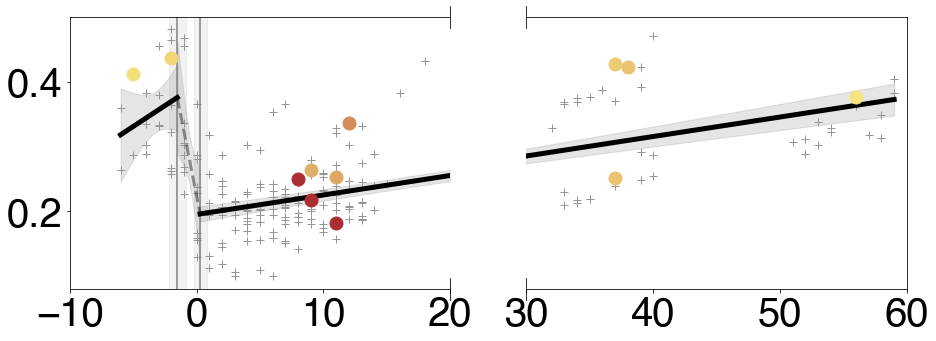

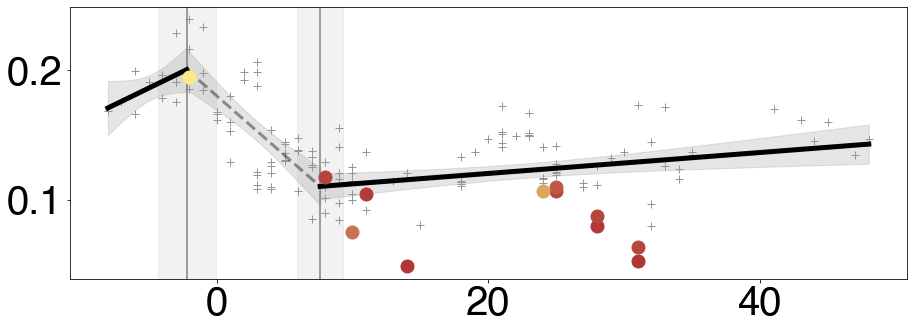

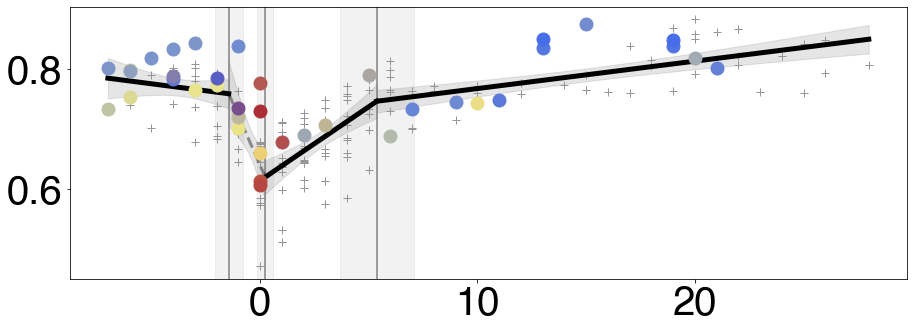

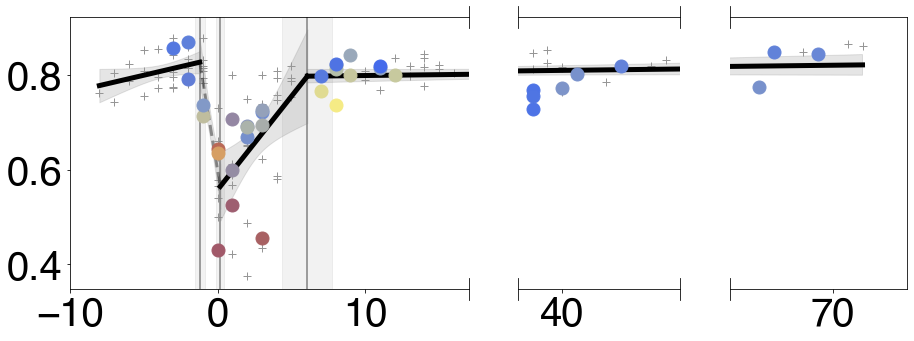

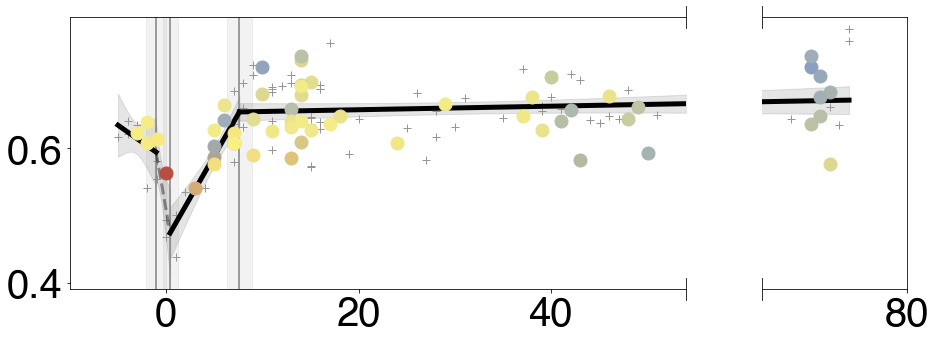

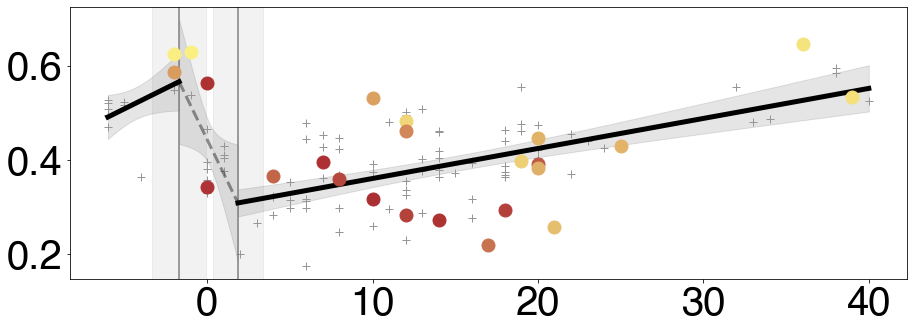

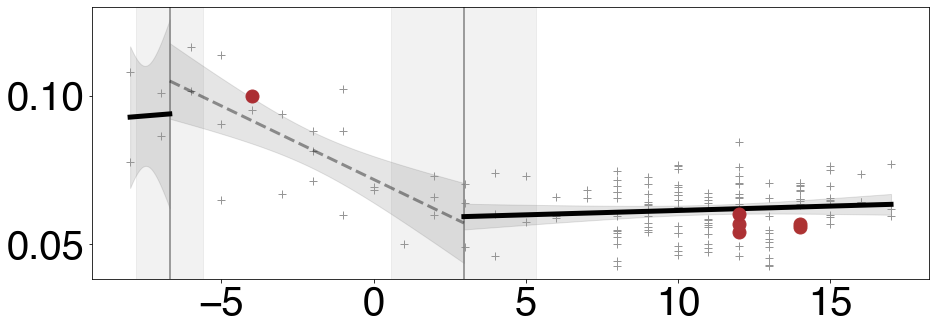

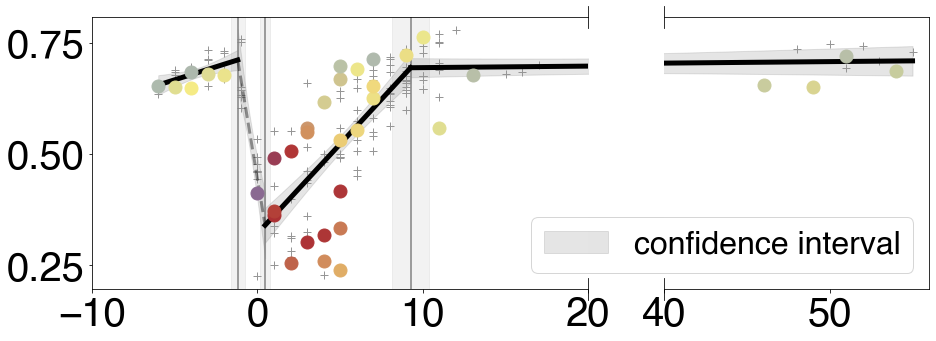

In [6]:
regions = ['CQTP','EBI','MD','NT','TL','WBI','WQTP','YP']
models = []
breakpoints_list = []


for region in regions:
    breakpoints,model, year_nt,ndvi_nt,color_list = fit_model(region,'./csv/SourceData_Fig1-3.xlsx')
    models.append(model)
    breakpoints_list.append(breakpoints)
    fig= plt.figure(figsize=(15,5))
    plt.rc('font',family='Helvetica',size=40,weight='bold')
    if region == 'CQTP':
        xlims = ((-10, 20),(30,60))#CQTP
    elif region == 'NT':
        xlims= ((-10, 17),(37,48), (63, 75)) #NT
    elif region == 'TL':
        xlims = ((-10,54), (65, 80)) #TL
    elif region == 'YP':
        xlims = ((-10, 20),(40,56)) # YP
    else:
        xlims = None # MD,WQTP,WS,WBI,EBI
   
    bax = brokenaxes(xlims=xlims, d=0.01,tilt=90, despine=False)

    for bp in breakpoints[1:-1]:
        bax.axvline(bp,color='grey')
    estimates = model.best_muggeo.best_fit.estimates
    # colors = ['#95e1d3','#f08a5d','#eaffd0']
    
    for bp_i in range(model.best_muggeo.n_breakpoints):
        bp_ci = estimates["breakpoint{}".format(
            bp_i + 1)]["confidence_interval"]
        bax.axvspan(bp_ci[0], bp_ci[1], alpha=0.1,color='grey')
   
    color = 'black' 
    
    if region == 'YP':
        draw_interval(breakpoints,ndvi_nt,year_nt,color,draw=True,draw_legend=True,bax=bax)
    else:
        draw_interval(breakpoints,ndvi_nt,year_nt,color,draw=True,draw_legend=False,bax=bax)


    for i in np.arange(len(year_nt)):
        # print(id_list_nt[i],ndvi_nt[i],color_list[i],ndvi_nt[i])
        if np.isnan(color_list[i][0]):
    #         print(i)
            color = (150/255,150/255,150/255,1)
            bax.plot(year_nt[i],ndvi_nt[i],'+',markersize = 8,color=color,label='Calibrated NDVI',zorder=1)
        else:
            # print(color_list[i][0],color_list[i][1],color_list[i][2])
            color = color_point(color_list[i][0],color_list[i][1],color_list[i][2],100)

            bax.plot(year_nt[i],ndvi_nt[i],'o',markersize = 13,color=color,label='Calibrated NDVI',zorder=2)


    plt.savefig('./images/%s_NDVI_vege.pdf'%(region),bbox_inches = 'tight') 

    

## Draw the triangular legend

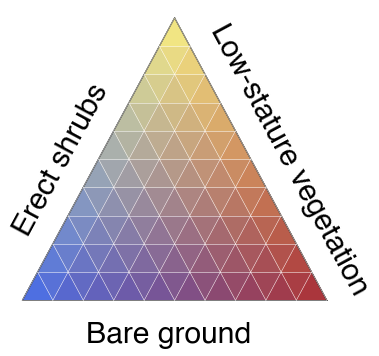

In [7]:
fig,ax = plt.subplots()
scale = 10
data = generate_heatmap_data(scale)
# print(data)
figure, tax = ternary.figure(scale=scale,ax=ax)
figure.set_size_inches(6, 6)
tax.heatmap(data, style="triangular", use_rgba=True,colorbar=False)

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

cb_kwargs = {"shrink" : 0.6,
             "orientation" : "horizontal",
             "fraction" : 0.1,
             "pad" : 0.05,
             "aspect" : 30}

tax.boundary(linewidth=1.0)
tax.gridlines(color="white", multiple=1, linewidth=0.5,ls='-')

# Set Axis labels and Title
fontsize = 30
tax.left_axis_label("Erect shrubs", fontsize=fontsize, offset=0.12)
tax.right_axis_label("Low-stature vegetation", fontsize=fontsize, offset=0.12)
tax.bottom_axis_label("Bare ground", fontsize=fontsize, offset=0.07)

plt.savefig('./images/PFT_tax.pdf',bbox_inches = 'tight')

# Figure 2--PFT

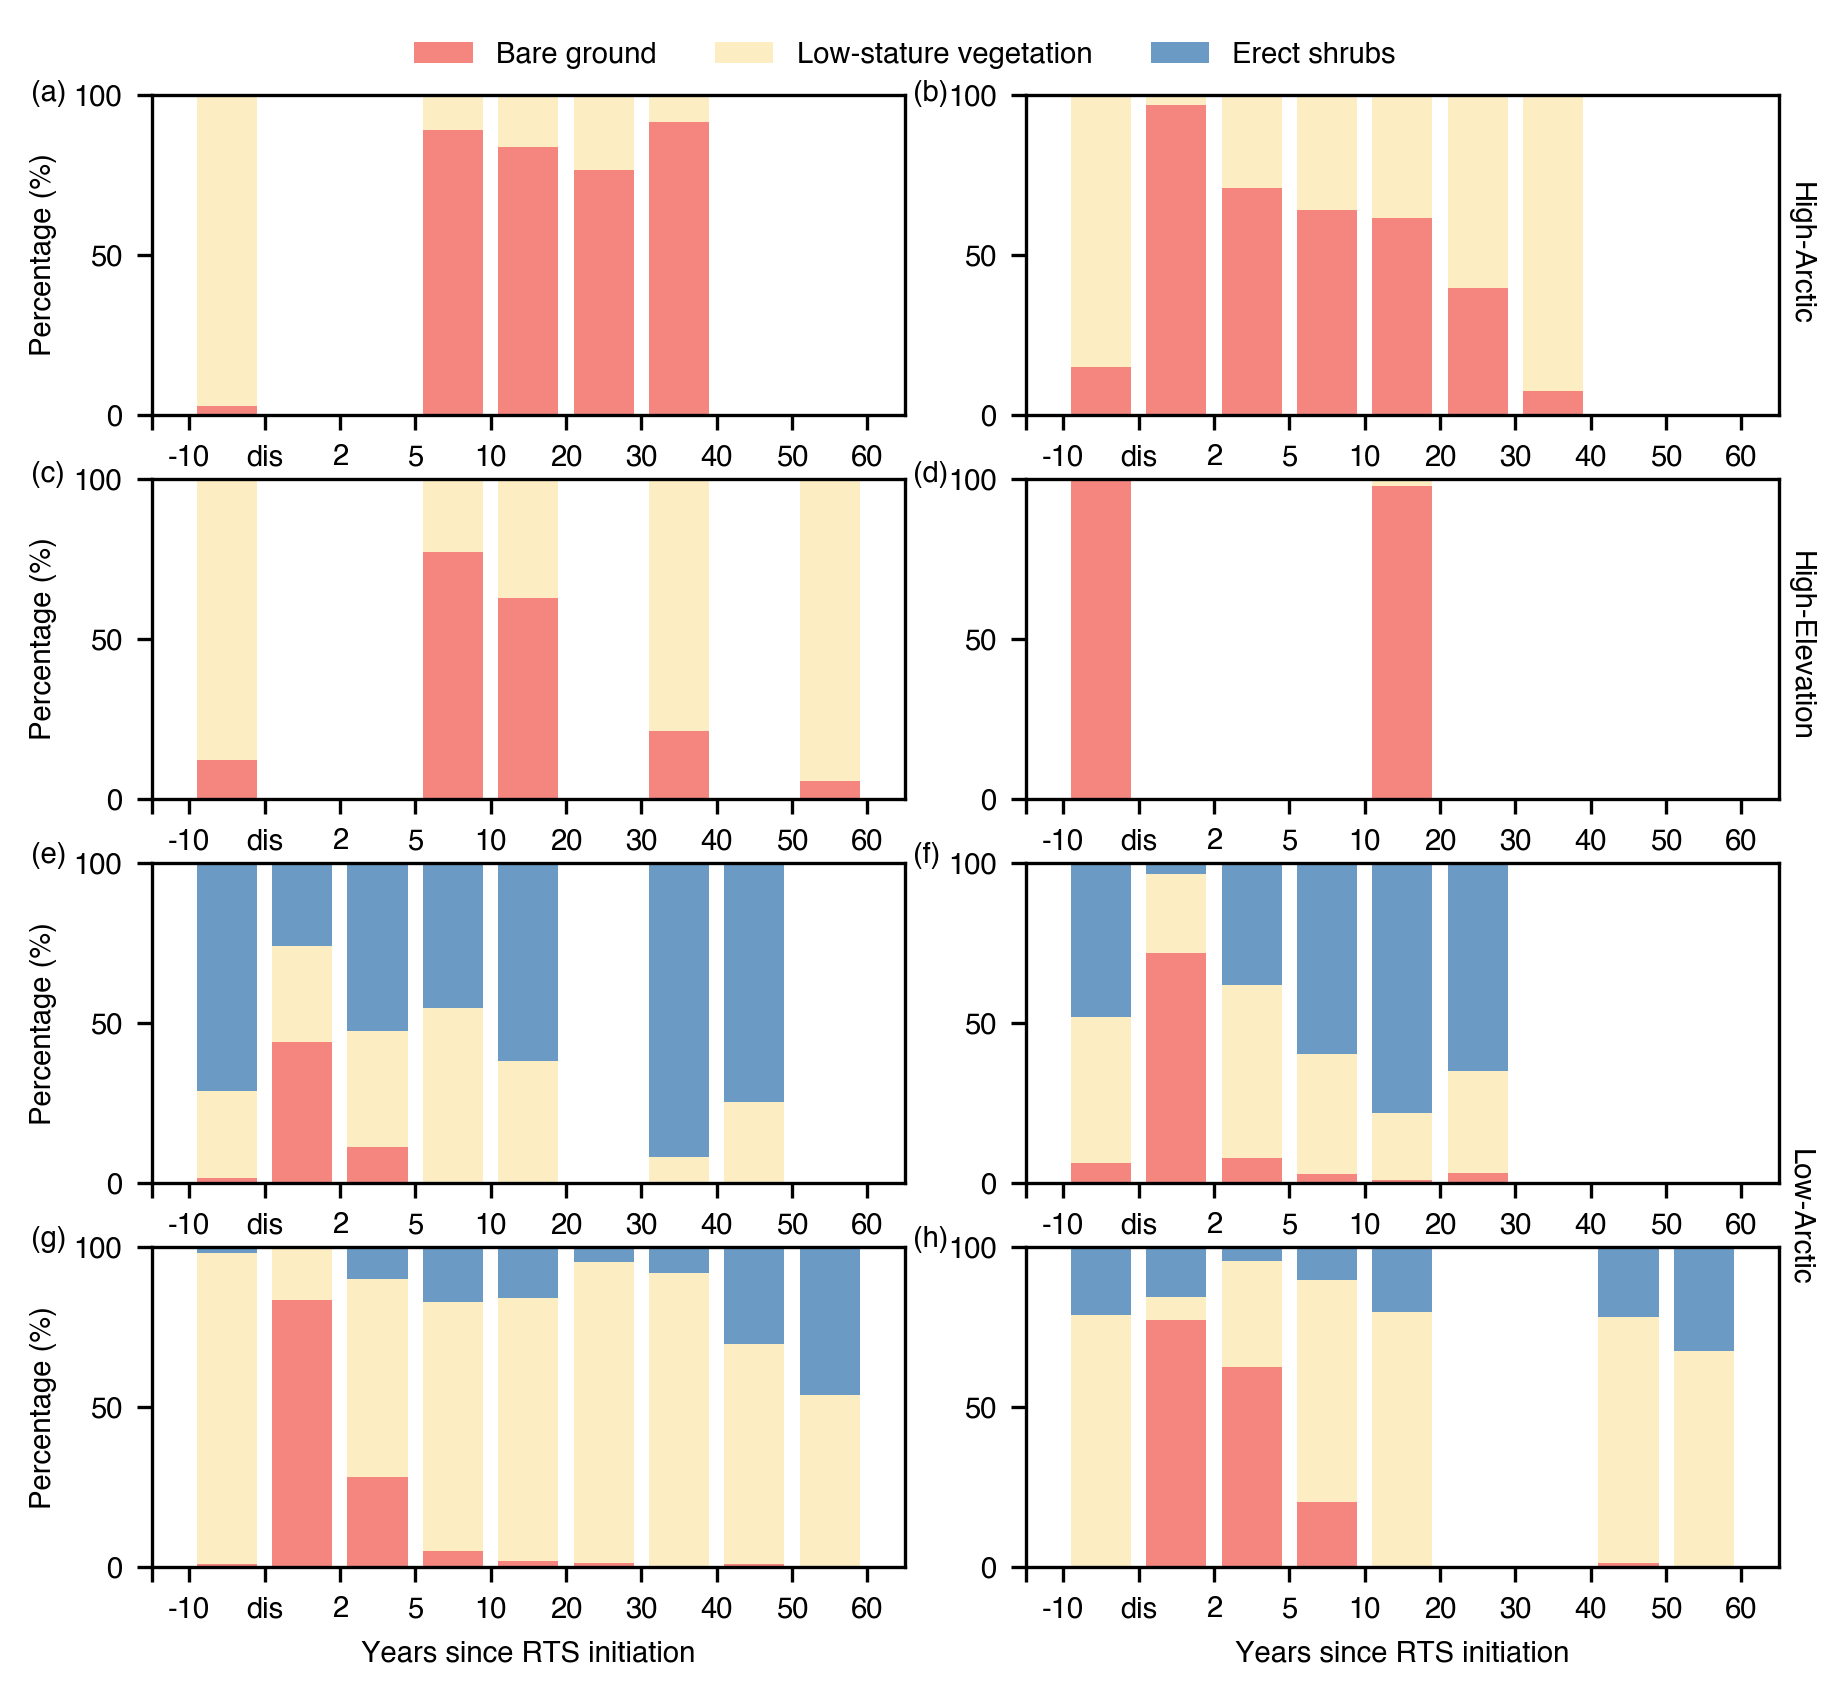

In [8]:
regions = ['EBI','WBI','CQTP','WQTP','NT','MD','TL','YP']
plt.rc('font',family='Helvetica',size=7,weight='bold')

fig, axs = plt.subplots(4,2,figsize=(7,6.5),dpi=300)
fig.subplots_adjust(wspace=0.16, hspace=0.2)
for i in np.arange(4):
    for j in np.arange(2):
        axs[i][j].set_ylim(0, 100)
        axs[i][j].set_yticks([0, 50, 100])

k = 0
for region in regions:
    file_name_csv = './csv/SourceData_Fig1-3.xlsx'
    sheet_name = region
    df = pd.read_excel(file_name_csv,sheet_name=sheet_name)
    year_nt = df['year'].to_numpy()
    color_r = df['p_bare'].to_numpy()
    color_g = df['p_low_stature_vegetation'].to_numpy()
    color_b = df['p_erect_shrub'].to_numpy()
    color_list = np.vstack((color_r,color_g,color_b)).T

    
    year_range = [-10, 0, 2, 5, 10, 20, 30, 40, 50,60]
    
    ls_trend = []
    bg_trend = []
    es_trend = []
    for i in np.arange(len(year_range)-1):
        ls = 0
        es = 0
        bg = 0
        number_rts = 0
        number_ndvi = 0
        for j in np.arange(len(year_nt)):
            if (year_nt[j]>=year_range[i]) & (year_nt[j]<year_range[i+1]):
                # print('color_list:',color_list[j],pft_trend[i,:])
                if np.isnan(color_list[j][0])==False:
                    ls += color_list[j].tolist()[1]
                    es += color_list[j].tolist()[2]
                    bg += color_list[j].tolist()[0]
                    number_ndvi= number_ndvi+1
        if number_ndvi == 0:
            ls_trend.append(0)
            es_trend.append(0)
            bg_trend.append(0)
        else:
            ls_trend.append(ls/number_ndvi)
            es_trend.append(es/number_ndvi)
            bg_trend.append(bg/number_ndvi)

    bottom = np.zeros(len(bg_trend))
    # print(np.arange(len(bottom)), bg_trend)
    axs[int(k/2),int(k%2)].bar(np.arange(len(bottom)),bg_trend,color='#f5867f',bottom=bottom,label='Bare ground')
    bottom = np.array(bg_trend) + bottom

    # print(np.arange(len(bottom)), ls_trend)
    axs[int(k/2),int(k%2)].bar(np.arange(len(bottom)),ls_trend,color='#FCEEC2',bottom=bottom,label='Low-stature vegetation')

    bottom = np.array(ls_trend) + bottom
    axs[int(k/2),int(k%2)].bar(np.arange(len(bottom)),es_trend,color='#6b9bc4',bottom=bottom,label='Erect shrubs')

    axs[int(k/2),int(k%2)].set_xlim(-1,len(bg_trend))
    axs[int(k/2),int(k%2)].set_xticks([-1, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])
    axs[int(k/2),int(k%2)].set_xticklabels(['','-10', 'dis', '2','5','10', '20', '30', '40', '50', '60'])

    axs[3,int(k%2)].set_xlabel('Years since RTS initiation')

    axs[int(k/2),0].set_ylabel('Percentage (%)')

    legend = axs[0,0].legend(
        loc='lower center',
        bbox_to_anchor=(1, 1),
        ncol=4,
        frameon=False
    )
    k = k+1
plt.text(-14.2,458,'(a)')
plt.text(-2.5,458,'(b)')

plt.text(-14.2,339,'(c)')
plt.text(-2.5,339,'(d)')

plt.text(-14.2,220,'(e)')
plt.text(-2.5,220,'(f)')

plt.text(-14.2,100,'(g)')
plt.text(-2.5,100,'(h)')

plt.text(9.1,390,'High-Arctic',rotation=270,fontsize=7)
plt.text(9.1,260,'High-Elevation',rotation=270,fontsize=7)

plt.text(9.1,90,'Low-Arctic',rotation=270,fontsize=7)

plt.savefig('./images/Figure-2.pdf',bbox_inches = 'tight')

# Figure 3--GPP

## Get revocery time

In [9]:
regions = ['CQTP','EBI','MD','NT','TL','WBI','WQTP','YP']

time_to_recovery_list = []
time_to_recovery_upper_list = []
time_to_recovery_lower_list = []

j = 0
for breakpoints in breakpoints_list:

    if len(breakpoints) == 4:
        time_ini = 0
        time_disturbanced = breakpoints[2]
        
        file_name_csv = './csv/SourceData_Fig1-3.xlsx'
        sheet_name = regions[j]
        df = pd.read_excel(file_name_csv,sheet_name=sheet_name)
        year_nt = df['year'].to_numpy()
        ndvi_nt  = df['ndvi'].to_numpy()

        index_dis=np.where(year_nt<time_ini)
        ndvi_undis = np.nanmean(ndvi_nt[index_dis])
        ndvi_dis = models[j].predict([time_disturbanced])[0]
        
        slope_with_ci,const = draw_interval(breakpoints,ndvi_nt,year_nt,color,draw = False)
        time_to_recover = (ndvi_undis-ndvi_dis)/slope_with_ci


    else:
        estimates = models[j].best_muggeo.best_fit.estimates
        bp_se = estimates["breakpoint{}".format(len(breakpoints)-2)]["se"] # std
        time_to_recover = unc.ufloat(breakpoints[3],bp_se)
    
    time_to_recovery_list.append(time_to_recover)

    j = j+1
print(time_to_recovery_list)

[49.371306548442895+/-4.365835528226342, 104.97510022923434+/-35.81823907345435, 5.371682831978362+/-0.8671428895986073, 6.081966577449519+/-0.8530304230600947, 7.605157813114584+/-0.6534823415870388, 34.57329272475356+/-5.005227593460726, 103.90638915335492+/-90.08381439416513, 9.260916078545183+/-0.5705362873787864]


In [10]:
def fitted_line_and_conf_interval(x, params, cov_matrix, func_gpp):
    A, B = params
    a, b = unc.correlated_values(params, cov_matrix)
    # print(a,b)
    y_fit = func_gpp((a, b), x)
    nom = unp.nominal_values(y_fit)
    std = unp.std_devs(y_fit)
    return nom, nom - 2 * std, nom + 2 * std


In [11]:
file_name_csv = './csv/SourceData_Fig1-3.xlsx'
sheet_name = 'Climate-data'
DATA = pd.read_excel(file_name_csv,sheet_name=sheet_name, skiprows=[1])

GPP_mean = DATA['GPP_mean'].values/1000
GPP_sd = DATA['GPP_stdev'].values/1000


regions = ['CQTP','EBI','MD','NT','TL','WBI','WQTP','YP']
regions_validate = ['PP','CR','TP', 'HI']
labels = ['CQ','EB','MD','NT','TL','WB','WQ','YP']
labels_validate = 'Validation sites'

colors_regional = ['#BD818B','#9A4454','#203744','#496877','#5191AF','#DEC2C6','#572F36','#9DC8DF']

x = GPP_mean
y = unp.nominal_values(time_to_recovery_list)
y_err = unp.std_devs(time_to_recovery_list)
x_err = GPP_sd

def func_gpp(params, x):
    A, B = params
    return A * x ** B


model_obj = odr.Model(func_gpp)

X_pos = []
Y_pos = []
X_pos_err = []
Y_pos_err = []
for i in np.arange(len(x)):
    if x[i]>0:
        X_pos.append(x[i])
        Y_pos.append(y[i])
        X_pos_err.append(x_err[i])
        Y_pos_err.append(y_err[i])
data = odr.RealData(X_pos, Y_pos, sx=X_pos_err, sy=Y_pos_err)

# Create an ODR object
odr_obj = odr.ODR(data, model_obj, beta0=[1,-2])  # initial parameter guess

# Run the regression
output = odr_obj.run()

# Extract the fitted parameters and their standard errors
params = output.beta
param_errors = output.sd_beta

print("Fitted parameters:", params)
print("Parameter errors:", param_errors)

# Degrees of freedom
dof = len(x) - len(params)

# Calculate t-values for each parameter
t_values = params / param_errors

# Calculate p-values from the t-distribution
p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]
print("t-values:", t_values)
print("p-values:", p_values)

a = params[0]
b = params[1]

Y_fit = a*X_pos**b
r2 = r2_score(Y_pos,Y_fit)
print('r2',r2)


Fitted parameters: [ 1.35231891 -1.67903449]
Parameter errors: [0.41290744 0.25147785]
t-values: [ 3.27511397 -6.67666951]
p-values: [0.016925630679198278, 0.0005467097876619142]
r2 0.9654946851996561


## Validate the model

In [12]:
# Extract the covariance matrix
cov_matrix = output.cov_beta
# print("cov:", cov_matrix)

a_unc, b_unc = unc.correlated_values(params,cov_matrix)

x_validate = [0.5607, 0.3643, 0.26, 0.18]

for i in x_validate:
    print('Fitted recovery time:',func_gpp([a_unc,b_unc], i))

Fitted recovery time: 3.6+/-0.5
Fitted recovery time: 7.4+/-0.5
Fitted recovery time: 13.0+/-1.0
Fitted recovery time: 24.1+/-3.0


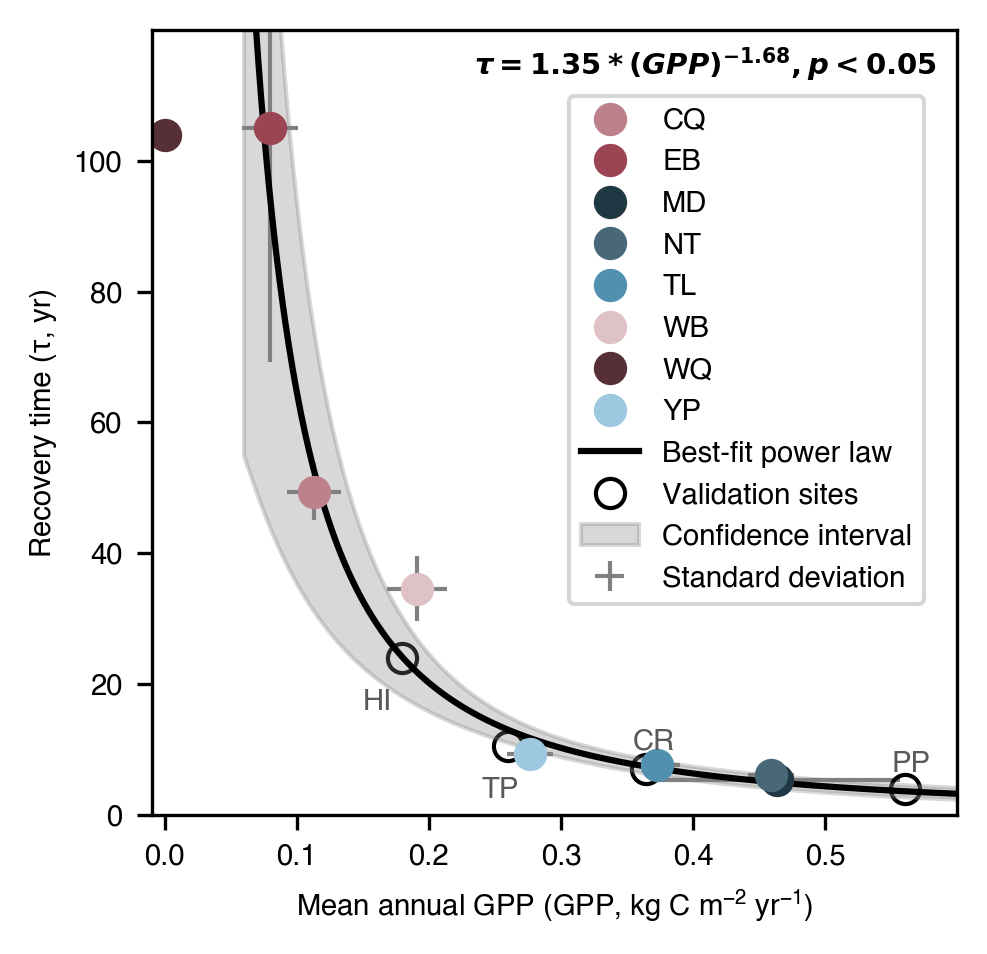

In [13]:
plt.rc( 'font', size=7, family="Helvetica" )
mm = 1/25.4
fig,ax = plt.subplots(figsize=(88*mm, 88*mm), dpi=300)
# Define new x values for the fitted line and confidence interval calculation
x_array = (np.arange(600)+60)/1000
y_fit, y_lower_conf, y_upper_conf = fitted_line_and_conf_interval(x_array, params, cov_matrix,func_gpp)

y_validate = [4,7,10.5,24]

plt.errorbar(X_pos,Y_pos, xerr=X_pos_err, yerr=Y_pos_err, fmt='o', markersize=0, elinewidth=1,color ='grey',label='Standard deviation',zorder=0)
for i in np.arange(len(x)):
    if x[i]>0:
        plt.plot(x[i],y[i],'o',color= colors_regional[i],label = labels[i],markersize=7,zorder=2)
        # print(y[i], x[i]-x_err[i], x[i]+x_err[i])
    else:
        plt.plot(x[i],y[i],'o',color= colors_regional[i],label = labels[i],markersize=7,zorder=2,alpha=1)
plt.plot(x_array, y_fit, color = 'black',label='Best-fit power law',zorder=1)
plt.fill_between(x_array, y_lower_conf, y_upper_conf, color='gray', alpha=0.3, label='Confidence interval')

plt.plot(x_validate,y_validate,'o',color= 'black',label = labels_validate,markersize=7,zorder=0,markerfacecolor='none')

plt.text(x_validate[0]-0.01,y_validate[0]+2.5,regions_validate[0],color='#595959')
plt.text(x_validate[1]-0.01,y_validate[1]+3,regions_validate[1],color='#595959')
plt.text(x_validate[2]-0.02,y_validate[2]-8,regions_validate[2],color='#595959')
plt.text(x_validate[3]-0.03,y_validate[3]-8,regions_validate[3],color='#595959')

plt.ylabel('Recovery time (τ, yr)')

plt.xlabel('Mean annual GPP (GPP, kg C $\mathregular{m^{-2}}$ $\mathregular{yr^{-1}}$)')
plt.xlim(-0.01,0.60)
xlabel = np.arange(6)/10
plt.xticks(np.linspace(0, 0.5, 6),xlabel)

plt.ylim(0,120)
plt.yticks(np.linspace(0, 100, 6))
equation_text = f'$τ = {params[0]:.2f} * (GPP)^{{{params[1]:.2f}}},p<0.05$'

plt.text(0.40, 0.98, equation_text, transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')

plt.legend(bbox_to_anchor=(1, 0.95))
plt.legend(bbox_to_anchor=(0.5, 0.25))
plt.savefig('./images/Figure-3.pdf',bbox_inches = 'tight')
# plt.show()

# Extended Data Figure 2--Precipitation & temperature

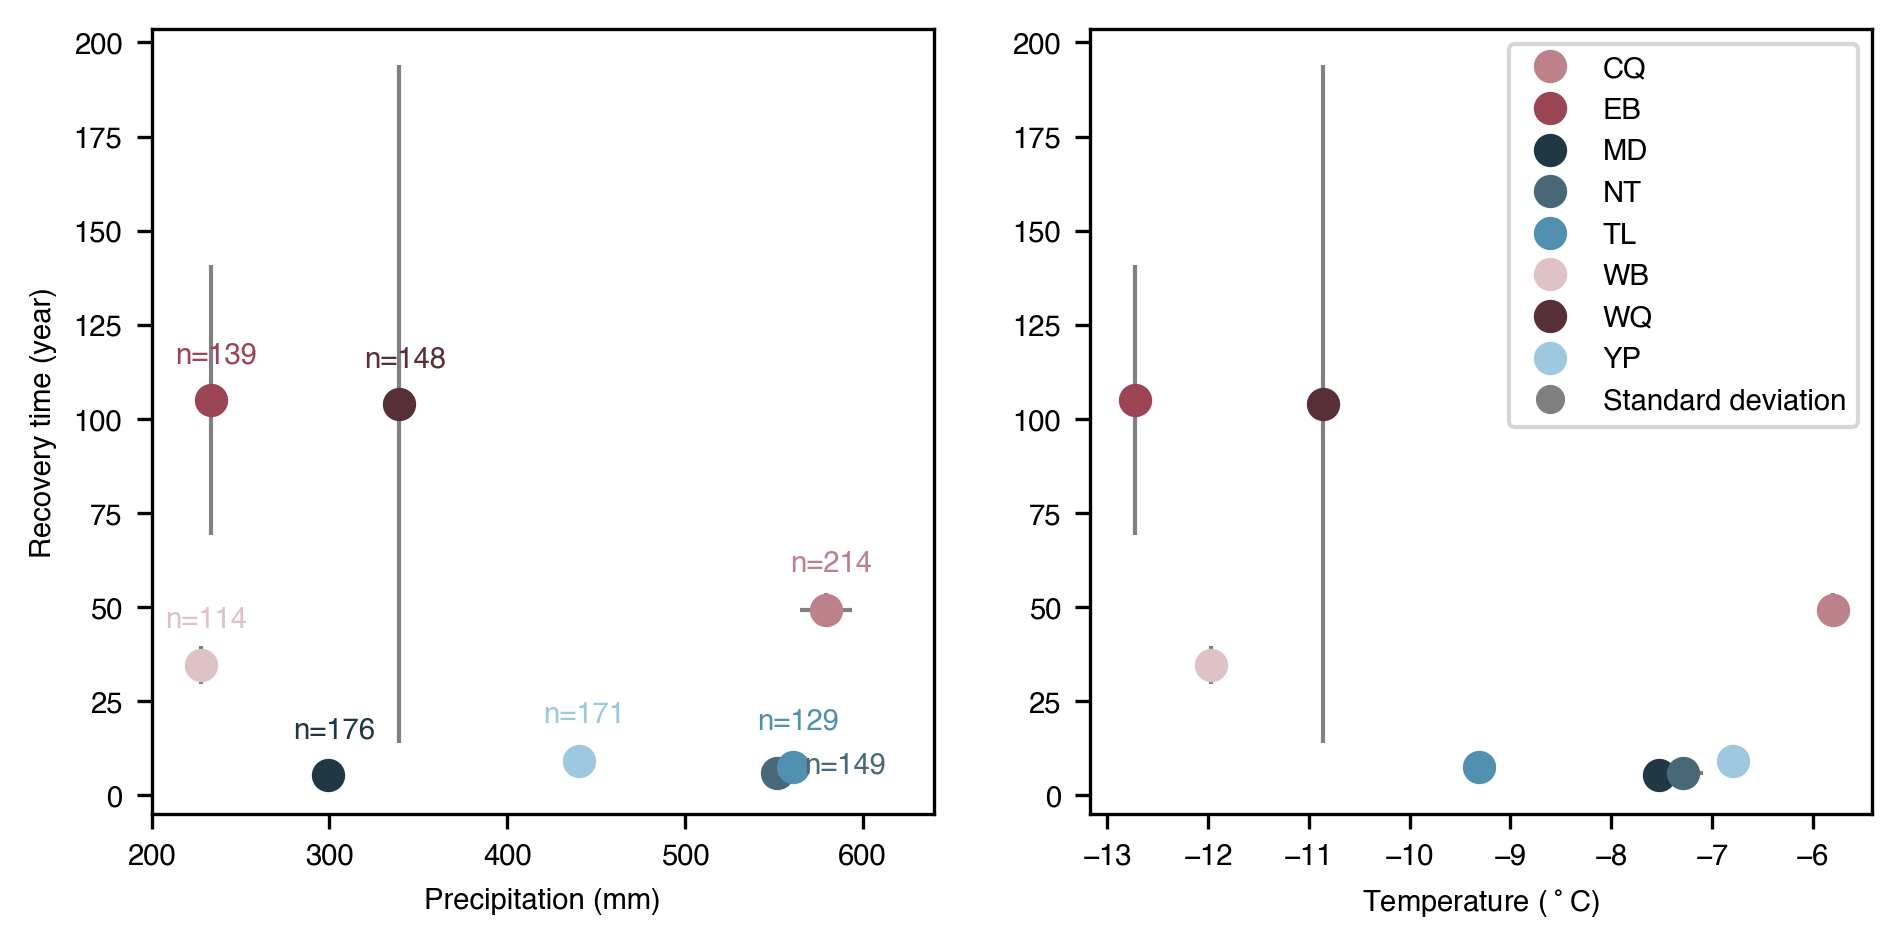

In [14]:
pre_mean = DATA['P_mean'].values
pre_std = DATA['P_stdev'].values
tem_mean = DATA['T_mean'].values
tem_std = DATA['T_stdev'].values
region = DATA['region'].values

colors_regional = ['#BD818B','#9A4454','#203744','#496877','#5191AF','#DEC2C6','#572F36','#9DC8DF']
labels = ['CQ','EB','MD','NT','TL','WB','WQ','YP']


y = unp.nominal_values(time_to_recovery_list)
y_err = unp.std_devs(time_to_recovery_list)
# print(x_err)
plt.rc( 'font', size=7, family="Helvetica" )
fig, axs = plt.subplots(1,2,figsize=(188*mm, 88*mm), dpi=300)

for i in np.arange(len(y)):
    file_name_csv = './csv/SourceData_Fig1-3.xlsx'
    sheet_name = regions[i]
    df = pd.read_excel(file_name_csv,sheet_name=sheet_name)
    
    ndvi_nt  = df['ndvi'].to_numpy()
    count_point = np.sum(~np.isnan(ndvi_nt))

    yerr = y_err[i]
    xerr = pre_std[i]
#     print(pre_all[:,0][i],x[i],yerr,xerr,pre_mean[i])
    axs[0].errorbar(pre_mean[i],y[i],  xerr = xerr, yerr = yerr, fmt='o', elinewidth=1, color ='grey',zorder=0)
    axs[0].plot(pre_mean[i],y[i],'o',color= colors_regional[i],label = labels[i],markersize=7,zorder=2)

    if regions[i] == 'NT':
        axs[0].text(pre_mean[i]+15,y[i]-0, 'n='+str(count_point),color = colors_regional[i], fontsize=7)
    else:
        axs[0].text(pre_mean[i]-20,y[i]+10, 'n='+str(count_point),color = colors_regional[i], fontsize=7)

    yerr = y_err[i]
    xerr = tem_std[i]
    axs[1].errorbar(tem_mean[i], y[i], xerr = xerr, yerr = yerr, fmt='o', elinewidth=1, color ='grey',zorder=0,label='Standard deviation')
    axs[1].plot(tem_mean[i],y[i],'o',color = colors_regional[i],label = labels[i],markersize=7,zorder=2)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1))

axs[0].set_ylabel("Recovery time (year)")
axs[0].set_xlabel("Precipitation (mm)")
axs[0].set_xlim(200,640)

axs[1].set_xlabel("Temperature ($^\circ$C)")
plt.savefig('./images/ED_Figure_3.jpg',bbox_inches = 'tight')